In [28]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
from pandas import DataFrame, Series
from numpy import nan as NA
import math

In [2]:
data=DataFrame(np.array([[-0.86,-0.30,-0.05,0.73],[5,5,5,5],[0,1,3,5]]),index=["Dose","Number of animals","Number of deaths"]).T
print data

   Dose  Number of animals  Number of deaths
0 -0.86                  5                 0
1 -0.30                  5                 1
2 -0.05                  5                 3
3  0.73                  5                 5


In [5]:
n=data.ix[:,1]
y=data.ix[:,2]
x=data.ix[:,0]

In [207]:
def invlogit(alpha,beta,x):
    invlogit=np.exp(alpha+beta*x)/(1+np.exp(alpha+beta*x))
    return invlogit

def log_p_th(th,n,y,x):
    alpha=th[0]
    beta=th[1]
    return alpha*np.sum(y)+beta*np.sum(y*x)-np.sum(n*np.log(1+np.exp(alpha+beta*x)))
    
def gradient_th(th,n,y,x):
    alpha=th[0]
    beta=th[1]
    d_alpha=np.sum(y)-np.sum(n*invlogit(alpha,beta,x))
    d_beta=np.sum(y*x)-np.sum(n*x*invlogit(alpha,beta,x))
    return np.array([d_alpha,d_beta])

def gradient_numerical_th(th,n,y,x):
    alpha=th[0]
    beta=th[1]
    e=0.0001
    hi_alpha=alpha+e
    hi_beta=beta+e
    lo_alpha=alpha-e
    lo_beta=alpha-e
    diff_alpha=1.*(log_p(hi_alpha,beta,n,y,x)-log_p(lo_alpha,beta,n,y,x))/2*e
    diff_beta=1.*(log_p(alpha,hi_beta,n,y,x)-log_p(alpha,lo_beta,n,y,x))/2*e
    return np.array([diff_alpha,diff_beta])
    
def hmc_iteration(th,n,y,x,epsilon,L,M):
    count=0
    M_inv=1./M
    d=len(th)
    phi=np.random.normal(0,np.sqrt(M),size=d)
    th_old=th
    log_p_old=log_p_th(th,n,y,x)-0.5*np.sum(M_inv*phi**2)
    phi=phi+0.5*epsilon*gradient_th(th,n,y,x)
    
    for l in range(L):
        th=th+epsilon*M_inv*phi
        if l==L:
            phi=phi+0.5*epsilon*gradient_th(th,n,y,x)
        else:
            phi=phi+0.5*epsilon*gradient_th(th,n,y,x)
        
    phi=-phi
    log_p_star=log_p_th(th,n,y,x)-0.5*sum(M_inv*phi**2)
    r=np.exp(log_p_star-log_p_old)
    
    if math.isnan(r):
        r=0.0
    
    p_jump=np.min([r,1])
    if p_jump>np.random.uniform():
        th_new=th
        count+=1
    else:
        th_new=th_old
        
    return np.array([th_new.tolist(),p_jump,count])


def hmc_run(starting_values,iter,epsilon_0,L_0,M):
    count=0
    chains=len(starting_values)
    d=len(starting_values[0])
    warmup=int(0.5*iter)
    
    p_jump=[]
    sims=[]
        
    for j in range(chains):
        p_jump.append([])
        sims.append([])
        for k in range(d):
            sims[j].append([])
        
        th=starting_values[j,:]
        for t in range(iter):
            epsilon=np.random.uniform(0,2*epsilon_0)
            L=int(np.ceil(2*L_0*np.random.uniform()))
            temp=hmc_iteration(th,n,y,x,epsilon,L,M)
            
            if temp[2]==1:
                count+=1
                
            p_jump[j].append(temp[1])
            for k in range(d):
                sims[j][k].append(temp[0][k])
           
    sim_value=[]
    for k in range(d):
        sim_value.append([])
    for j in range(chains):
        for k in range(d):
            sim_value[k].extend(sims[j][k][warmup:])
            
    return np.array([sim_value,p_jump,1.*count/(chains*iter)])
            
            
    
def posterior(alpha,beta,y,n,x):
    posterior_dens=[]
    for i in range(len(alpha)):
        grid=[]
        for j in range(len(beta)):
            A=1.0
            for k in range(len(x)):
                A=A*np.power(invlogit(alpha[i],beta[j],x[k]),y[k])*np.power(1-invlogit(alpha[i],beta[j],x[k]),n[k]-y[k])
            grid.append(A)
        posterior_dens.append(grid)
    return posterior_dens
    
def summ(x):
    percentile=np.percentile(x,[2.5,25,50,75,97.5]).tolist()
    summ=[np.mean(x),np.std(x)]
    summ.extend(percentile)
    summ=DataFrame(summ,index=["mean","sd","2.5%","25%","50%","75%","97.5%"],columns=["info"]).T
    return summ

In [218]:
mass_vector=np.array([1./10**2,1./10**2])

m=1
d=2

starting_values=[]
for i in range(m):
    starting_values.append([])
    for j in range(d):
        starting_values[i].append(np.random.uniform(0,15))
starting_values=np.array(starting_values)

In [221]:
mc1=hmc_run(starting_values,iter=500,epsilon_0=0.1,L_0=10,M=mass_vector)

In [222]:
mc1[2]

0.698

In [223]:
summ(mc1[0][0])

,mean,sd,2.5%,25%,50%,75%,97.5%
info,3.642846,3.644611,-4.283678,1.175734,5.743363,6.169697,8.160806


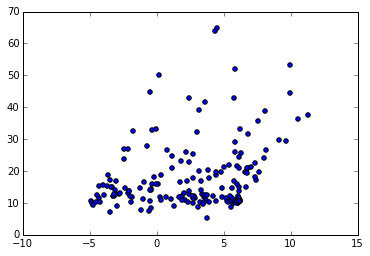

In [224]:
plt.scatter(mc1[0][0],mc1[0][1])